In [20]:
import bayesnewton
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.spatial.distance import cdist
from bayes_opt import BayesianOptimization
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import sys, os
sys.path.append('../../Utils')
import model_utils as mutils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
data =  pd.read_csv('../../../Data/pv_power_df_5day_capacity_scaled.csv', index_col='datetime')
uk_pv = pd.read_csv('../../../Data/system_metadata_location_rounded.csv')
uk_pv['ss_id_string'] = uk_pv['ss_id'].astype('str')

lats = dict(uk_pv.set_index('ss_id')['latitude_noisy'])
longs = dict(uk_pv.set_index('ss_id')['longitude_noisy'])

In [22]:
#DATA VARIABLES
SYSTEMS_NUM = 100
TIMESTEPS_NUM = 50000
TRAIN_FRAC = 24  
TEST_STATIONS = 75

In [23]:
#TRAIN
data_multiple = data.iloc[:, :SYSTEMS_NUM][:TIMESTEPS_NUM].reset_index()
stacked = mutils.stack_dataframe(data_multiple, lats, longs)
capacities = uk_pv[uk_pv.ss_id_string.isin(data_multiple.columns)].set_index('ss_id_string')['kwp'].values * 1000

X = np.array(stacked[['epoch', 'longitude', 'latitude']])
Y = np.array(stacked[['PV']])
#Create a space-time grid from X and Y
t, R, Y = bayesnewton.utils.create_spatiotemporal_grid(X, Y)


#TEST
data_unseen = data.iloc[:, SYSTEMS_NUM:SYSTEMS_NUM+TEST_STATIONS][:TIMESTEPS_NUM].reset_index()
capacities_unseen = uk_pv[uk_pv.ss_id_string.isin(data_unseen.columns)].set_index('ss_id_string')['kwp'].values * 1000
stacked_unseen = mutils.stack_dataframe(data_unseen, lats, longs)
X_unseen = np.array(stacked_unseen[['epoch', 'longitude', 'latitude']])
Y_unseen = np.array(stacked_unseen[['PV']])
t, R_unseen, Y_unseen = bayesnewton.utils.create_spatiotemporal_grid(X_unseen, Y_unseen)

del data,uk_pv

In [24]:
R_scaler = StandardScaler().fit(R[0])
R_scaled = np.tile(R_scaler.transform(R[0]), (R.shape[0],1, 1)) #renormalise R and project across time
R_scaled_unseen = np.tile(R_scaler.transform(R_unseen[0]), (R_unseen.shape[0],1, 1)) #renormalise R and project across time


In [25]:
def evaluate_IDW(power, time_factor, neighbours_space, neighbours_time, t_train, R_train, Y_train, t_test, R_test, Y_test, capacities_test, mini_batch = 1024):
    '''
    Function that calculates the IWD prediction for a single helf out system
    power - power of distance metric
    time_factor - factor that governs the weighted sum between time and space dimension
    
    returns:
    - MAE of the predictor (averages over all systems)
    - prediction for that specific location and timestep
    
    '''
    print('beginning IDW')
    
#     print('get space neighbours')
    nbrs_space = NearestNeighbors(n_neighbors=neighbours_space, algorithm='ball_tree').fit(R_train)
    distances_neighbours_space, idx_neighbours_space = nbrs_space.kneighbors(R_test)
    
    nbrs_time = NearestNeighbors(n_neighbors=neighbours_time, algorithm = 'kd_tree', p=1).fit(t_train)
    distances_neighbours_time, idx_neighbours_time = nbrs_time.kneighbors(t_test)
    
    predictions_list = []
    MAE_list = []
    Y_MW = Y_test * capacities_test
    
    for first in range(0, len(distances_neighbours_time), mini_batch):
        distances_neighbours_time_batch = distances_neighbours_time[first:first+mini_batch]
        idx_neighbours_time_batch = idx_neighbours_time[first:first+mini_batch]
        len_batch = len(distances_neighbours_time_batch)
        distances = np.add.outer(distances_neighbours_space.T, distances_neighbours_time_batch.T).swapaxes(0,3)
        weights = (1 / distances)** power
        del distances
        norm_weights = weights / np.sum(weights, axis = (2,3))[:,:, np.newaxis, np.newaxis]
        del weights
        y_neighbours = Y_train[idx_neighbours_time_batch][:,:, idx_neighbours_space].swapaxes(1,2)
        
        prediction = np.sum(norm_weights * y_neighbours, axis = (2,3)) 
        predictions_list.append(prediction)
        del norm_weights

    predictions = np.vstack(predictions_list)
    MAE = (np.nanmean((abs(Y_test - predictions) )))
        
    print('Terminated IDW')
    
    return predictions, MAE



beginning IDW
Terminated IDW


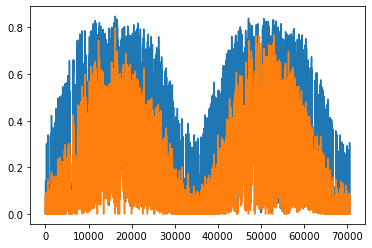

In [7]:
power = 2
time_factor = 1/10
neighbours_space = 20
neighbours_time = 50
predictions, MAE = evaluate_IDW(power, time_factor, neighbours_space, neighbours_time, t, R_scaled[0], Y[:,:,0], t, R_scaled_unseen[0], Y_unseen[:,:,0], capacities_unseen)
plt.plot(predictions[:,10])
plt.plot(Y_unseen[:,10])

In [7]:
def opt_IDW(power, time_factor, n_space, n_time):
    '''
    Wrapper function for bayesian opt of evaluate IDW
    '''
    
    neighbours_space = int(n_space)
    neighbours_time = int(n_time)
    
    predictions, MAE = evaluate_IDW(power, time_factor, neighbours_space, neighbours_time, t, R_scaled[0], Y[:,:,0], t, R_scaled_unseen[0], Y_unseen[:,:,0], capacities_unseen)
    #return the negative value 
    return - MAE



In [8]:
optimiser = BayesianOptimization(
        f = opt_IDW,
        pbounds = {'power' : (0.01, 5), 'time_factor': (0.01, 1), 'n_space': (2, 20), 'n_time': (5, 50)},
        verbose = 2
        )
optimiser.maximize(n_iter = 50, init_points = 6)
print('final result',optimiser.max)

|   iter    |  target   |  n_space  |  n_time   |   power   | time_f... |
-------------------------------------------------------------------------
beginning IDW
Terminated IDW
|  1        | -0.11     |  17.55    |  12.5     |  4.86     |  0.08821  |
beginning IDW
Terminated IDW
|  2        | -0.1008   |  9.702    |  21.78    |  0.754    |  0.1827   |
beginning IDW
Terminated IDW
|  3        | -0.1028   |  12.9     |  17.56    |  2.331    |  0.5114   |
beginning IDW
Terminated IDW
|  4        | -0.1071   |  13.8     |  32.12    |  3.618    |  0.8213   |
beginning IDW
Terminated IDW
|  5        | -0.1012   |  19.78    |  29.97    |  1.43     |  0.936    |
beginning IDW
Terminated IDW
|  6        | -0.1006   |  7.931    |  16.24    |  1.375    |  0.2229   |
beginning IDW
Terminated IDW
|  7        | -0.1098   |  5.676    |  20.06    |  4.24     |  0.8948   |
beginning IDW
Terminated IDW
|  8        | -0.1071   |  4.865    |  49.0     |  0.2261   |  0.6052   |
beginning IDW
Terminated IDW

Terminated IDW
|  55       | -0.1021   |  8.789    |  8.264    |  0.01     |  1.0      |
beginning IDW
Terminated IDW
|  56       | -0.1053   |  2.0      |  9.017    |  0.01     |  0.01     |
final result {'target': -0.10023910205000514, 'params': {'n_space': 9.670563315718798, 'n_time': 18.570011476844705, 'power': 0.9053430128116193, 'time_factor': 0.1746815006862631}}


# RUN WITH OPTIMAL HYPERPARAMS

In [26]:
optimiser_max = {'target': -0.10023910205000514, 'params': {'n_space': 9.670563315718798, 'n_time': 18.570011476844705, 'power': 0.9053430128116193, 'time_factor': 0.1746815006862631}}

beginning IDW
Terminated IDW


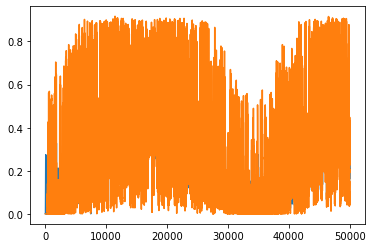

In [27]:
power = optimiser_max['params']['power']
time_factor = optimiser_max['params']['time_factor']
neighbours_space = int(optimiser_max['params']['n_space'])
neighbours_time = int(optimiser_max['params']['n_time'])
predictions, MAE = evaluate_IDW(power, time_factor, neighbours_space, neighbours_time, t, R_scaled[0], Y[:,:,0], t, R_scaled_unseen[0], Y_unseen[:,:,0], capacities_unseen)
plt.plot(predictions[:,10])
plt.plot(Y_unseen[:,10])

In [28]:
print(f'THE BENCHMARK MAE IS {MAE}')

THE BENCHMARK MAE IS 0.10072008335928678
